<a href="https://colab.research.google.com/github/Jomaleesmith/HUDS/blob/main/Final_Alabama_Choropleth_Map_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading and selecting data from the initial dataset...
Converting data columns to numeric type...
Aggregating data by county...
Data aggregated successfully. Head of aggregated data:
      NAME  S2801_C02_014E  S2801_C01_012E  S2801_C02_015E  S2801_C02_018E  \
0  Autauga       73.933333     1350.083333       52.258333        7.383333   
1  Baldwin       74.003226     1792.562500       50.351613        7.412903   
2  Barbour       56.677778      598.888889       35.155556        8.488889   
3     Bibb       62.625000     1076.750000       43.200000       11.250000   
4   Blount       65.088889     1542.333333       38.522222        7.488889   

   S2801_C02_013E  
0        0.516667  
1        0.793548  
2        1.600000  
3        0.525000  
4        1.500000  
Loading GeoJSON file...
GeoJSON loaded successfully. GeoJSON 'NAME' column head:
0    Lauderdale
1     Limestone
2       Colbert
3        DeKalb
4      Lawrence
Name: NAME, dtype: object
Merging geospatial and tabular data...
Me

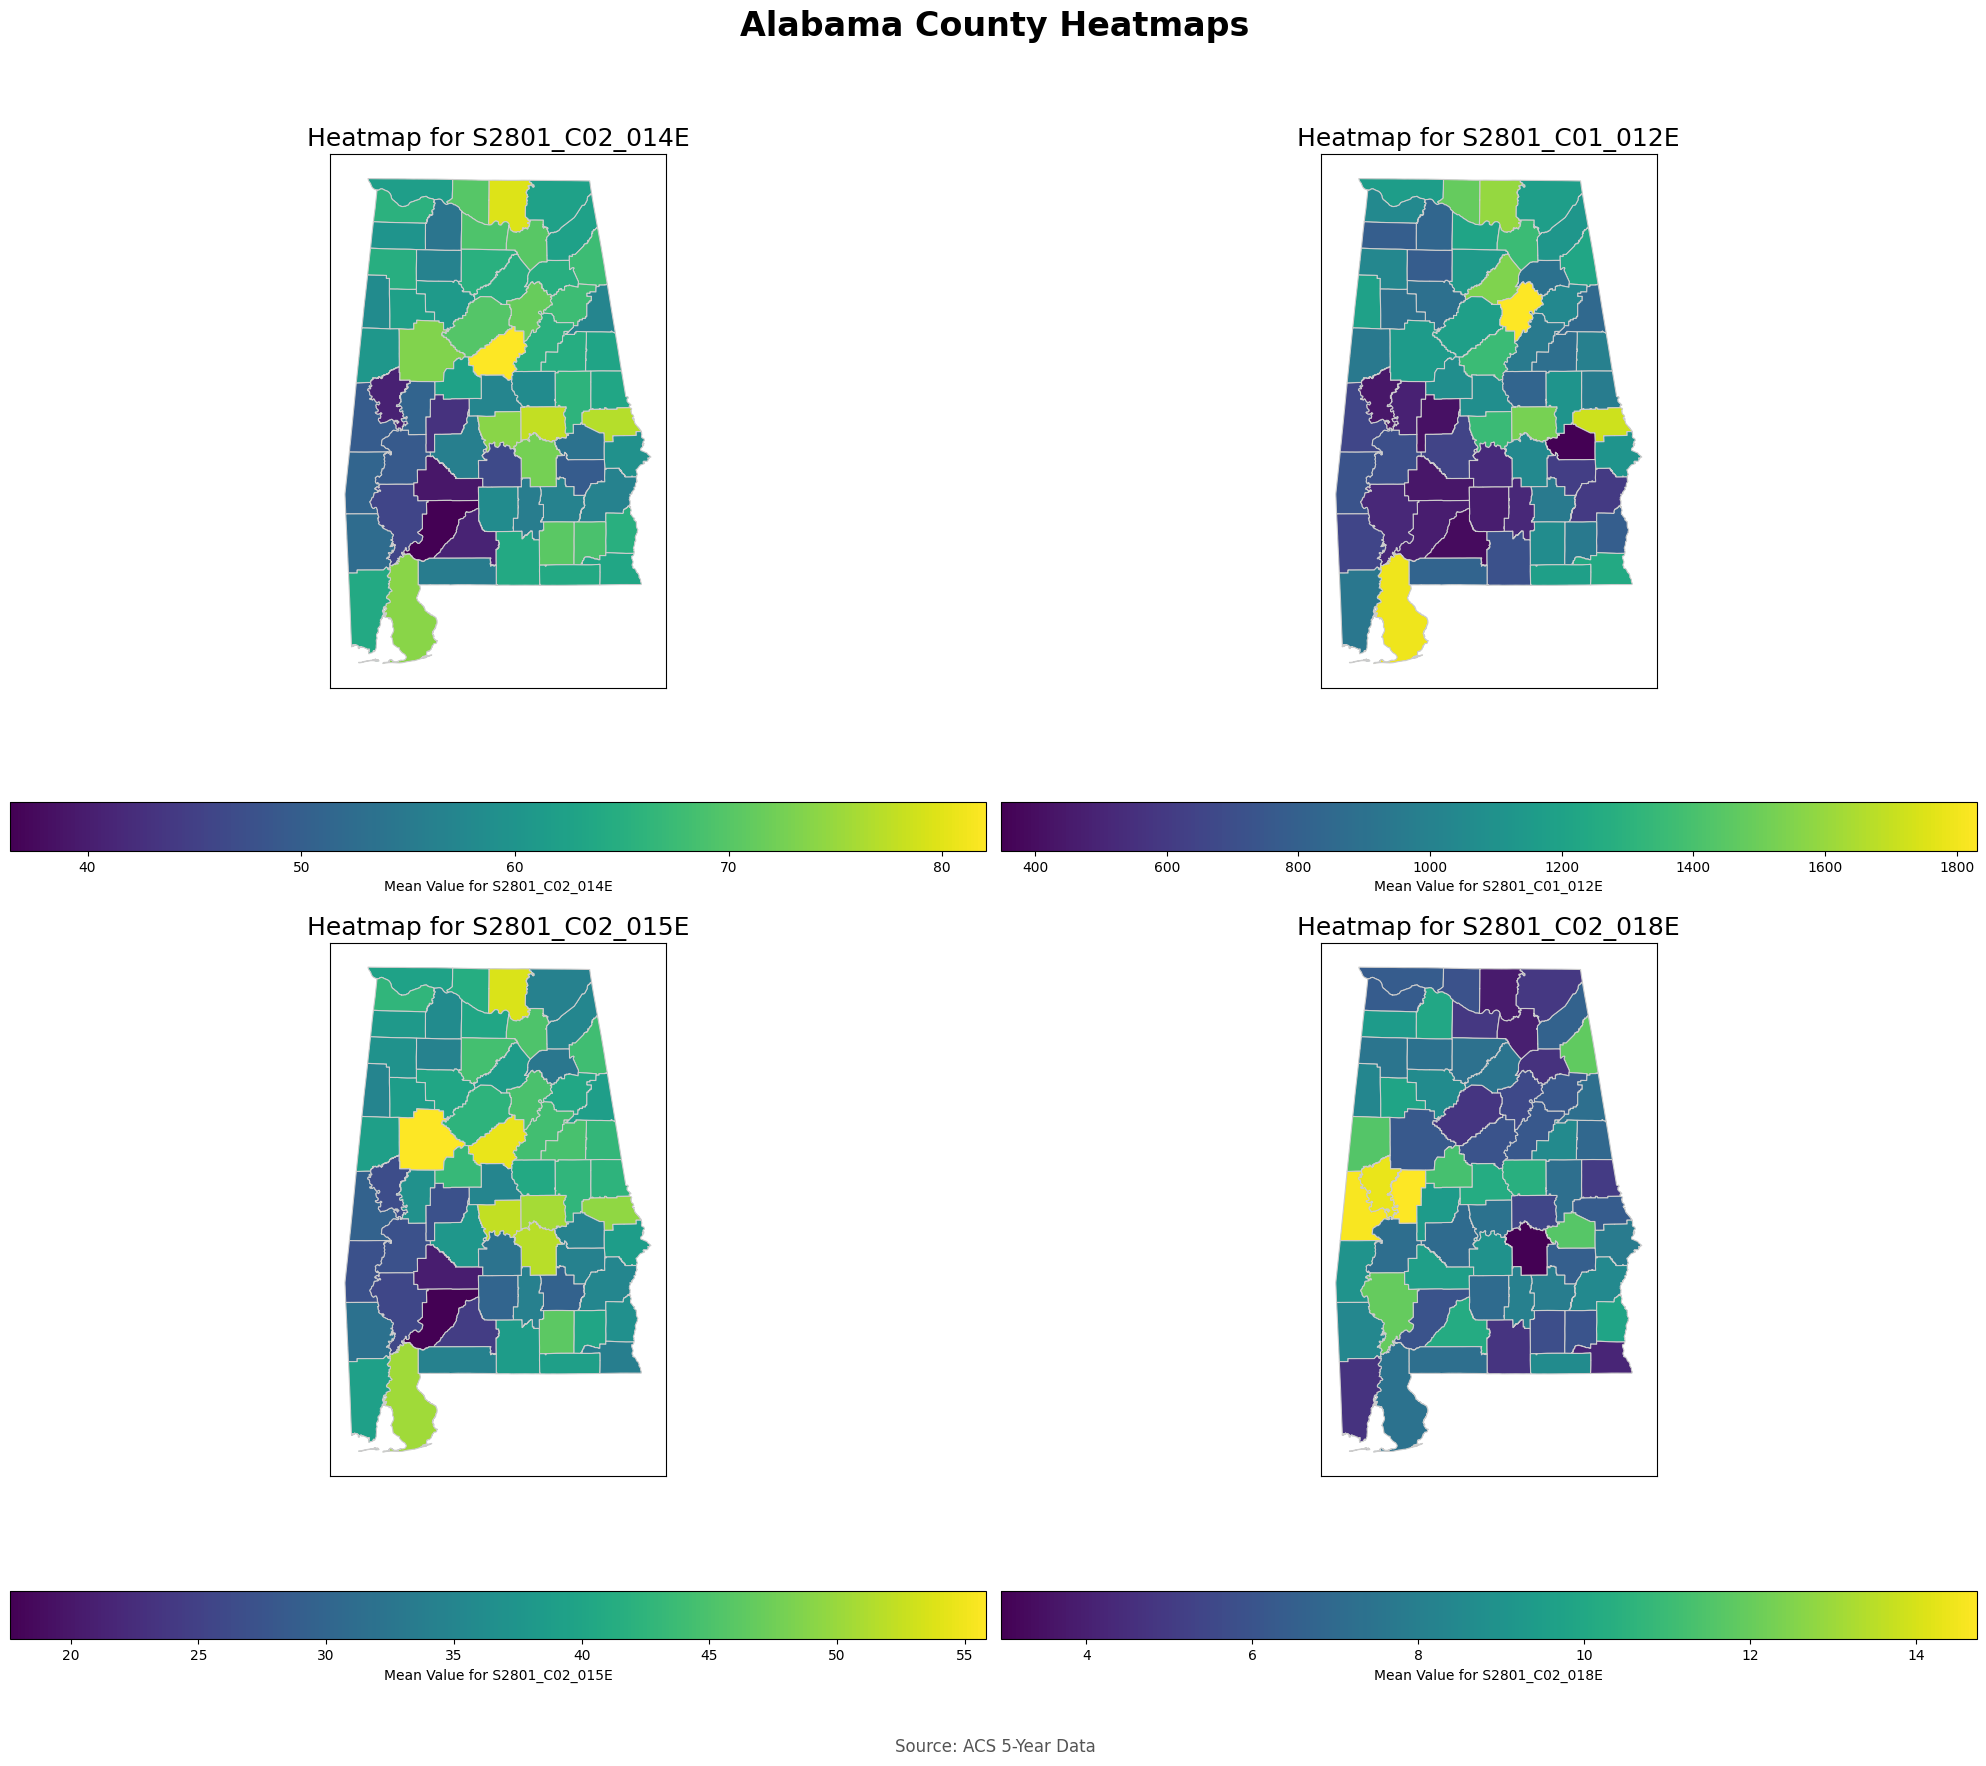

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

def generate_alabama_choropleth():
    """
    This function creates a choropleth map of Alabama counties from raw data.

    It performs the following steps:
    1. Loads the initial dataset.
    2. Selects the required columns.
    3. Converts data columns to a numeric type.
    4. Aggregates the data by county, calculating the mean.
    5. Loads the Alabama GeoJSON file.
    6. Merges the aggregated data with the geospatial data.
    7. Plots and displays the final choropleth maps in a grid.
    """
    try:
        # --- 1. File Paths ---
        raw_data_path = '/content/download (9).csv'
        geojson_path = '/content/Alabama_Counties.geojson'

        # --- 2. Load and Select Data ---
        print("Loading and selecting data from the initial dataset...")

        # Load the raw dataset
        df = pd.read_csv(raw_data_path)

        # Define the columns to keep
        columns_to_keep = ['NAME', 'S2801_C02_014E', 'S2801_C01_012E', 'S2801_C02_015E', 'S2801_C02_018E', 'S2801_C02_013E']

        # Filter the DataFrame to only the columns we need
        data_df = df[columns_to_keep].copy() # Use .copy() to avoid SettingWithCopyWarning

        # --- 3. Convert Data Columns to Numeric ---
        # The error "agg function failed [how->mean,dtype->object]" means some columns
        # that should be numbers are being treated as text (object). We need to convert them.
        print("Converting data columns to numeric type...")
        numeric_cols = ['S2801_C02_014E', 'S2801_C01_012E', 'S2801_C02_015E', 'S2801_C02_018E', 'S2801_C02_013E']
        for col in numeric_cols:
            # pd.to_numeric will attempt to change the column to a numeric type.
            # errors='coerce' will turn any value that can't be converted into NaN (Not a Number).
            data_df[col] = pd.to_numeric(data_df[col], errors='coerce')

        # --- 4. Data Aggregation ---
        # The new data file has the county name directly in the 'NAME' column.
        # We will group by the 'NAME' column directly to aggregate the data.
        print("Aggregating data by county...")
        county_data = data_df.groupby('NAME').mean().reset_index()

        if county_data.empty:
            print("\n--- ERROR ---")
            print("No data was successfully aggregated. Please check that the 'NAME' column")
            print(f"in '{raw_data_path}' contains the county names.")
            return

        print("Data aggregated successfully. Head of aggregated data:")
        print(county_data.head())

        # --- 5. Load Geospatial Data ---
        print("Loading GeoJSON file...")
        gdf = gpd.read_file(geojson_path)
        print("GeoJSON loaded successfully. GeoJSON 'NAME' column head:")
        print(gdf['NAME'].head())

        # --- 6. Merge Geospatial and Tabular Data ---
        print("Merging geospatial and tabular data...")

        # Prepare for merge: Ensure the join keys are consistent.
        # We'll use uppercase for both to avoid case-sensitivity issues.
        # The CSV `NAME` column and the GeoJSON `NAME` column should both contain county names.
        gdf['JOIN_NAME'] = gdf['NAME'].str.upper()
        county_data['JOIN_NAME'] = county_data['NAME'].str.upper()

        # Merge the GeoDataFrame with your aggregated data
        merged_gdf = gdf.merge(county_data, on='JOIN_NAME', how='left')
        print("Merge complete.")

        # --- 7. Create the Choropleth Maps ---
        # Define the list of columns you want to visualize
        columns_to_plot = ['S2801_C02_014E', 'S2801_C01_012E', 'S2801_C02_015E', 'S2801_C02_018E']

        # Create a figure with a 2x2 grid of subplots
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 18))

        # Flatten the 2x2 array of axes for easy iteration
        axes = axes.flatten()

        # --- 8. Customize and Plot each map ---
        # Loop through each column and its corresponding subplot axis
        for i, column_to_plot in enumerate(columns_to_plot):
            ax = axes[i] # Get the current axis

            # Plot the map
            merged_gdf.plot(column=column_to_plot,
                            cmap='viridis',
                            linewidth=0.8,
                            ax=ax,
                            edgecolor='0.8',
                            legend=True,
                            legend_kwds={'label': f"Mean Value for {column_to_plot}",
                                         'orientation': "horizontal"},
                            missing_kwds={'color': 'lightgrey',
                                          "hatch": "///",
                                          "label": "Missing values"})

            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f'Heatmap for {column_to_plot}', fontdict={'fontsize': '18', 'fontweight': '5'})

        # Add an overall title and source annotation for the entire figure
        fig.suptitle('Alabama County Heatmaps', fontsize=24, fontweight='bold')
        fig.text(0.5, 0.01, 'Source: ACS 5-Year Data', ha='center', va='bottom', fontsize=12, color='#555555')

        # Adjust layout to prevent titles from overlapping
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        print("Displaying maps...")
        plt.show()

    except FileNotFoundError as e:
        print(f"Error: A required file was not found. Please check your file paths.")
        print(f"Details: {e}")
    except KeyError as e:
        print(f"Error: A required column was not found in one of the data files.")
        print(f"Details: Could not find column {e}. Please check column names in your CSV and GeoJSON files.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# --- Run the main function ---
generate_alabama_choropleth()

# **S2801_C02_014E**
**Percent of households with a broadband Internet subscription**

This variable serves as the cornerstone of our analysis, providing a standardized measure of broadband access across geographic regions. By examining the percentage of households with a broadband subscription, we can effectively compare urban and rural areas, regardless of their population size. This metric directly captures the extent of internet connectivity and helps to identify counties or tracts where broadband access is disproportionately low. It is ideal for choropleth mapping and statistical modeling because it facilitates a meaningful comparison of broadband penetration rates across the urban-rural divide.

# **S2801_C01_012E**
**Total households with a broadband Internet subscription**

While percentages are useful for comparison, total counts give us critical context. This variable provides the raw number of households in each area that have a broadband subscription. It complements the percentage-based data by revealing the absolute size of the connected population. In rural areas with fewer households, this measure helps us validate whether low percentages reflect a genuine access issue or simply low population density. It also allows for assessing the scale of investment or infrastructure needed to expand broadband services.

# **S2801_C02_015E**
**Percent of households with a cellular data plan**

This variable captures the prevalence of cellular-based internet access, which is particularly relevant in rural areas where wired broadband infrastructure may be limited or nonexistent. A high percentage in this category may indicate that residents are relying on mobile data as a substitute for fixed broadband. Including this variable allows us to distinguish between areas with genuine broadband access and those where connectivity is achieved through less stable or slower mobile options. It serves as a proxy for understanding the adaptability of rural populations in the face of infrastructural gaps.

# **S2801_C02_018E**
**Percent of households with no Internet access**

This variable measures the most extreme form of digital exclusion: complete lack of internet access. It is a critical component of the digital divide, as it identifies households that are entirely disconnected from the digital economy, education, healthcare, and civic engagement. Including this measure enables us to identify geographic pockets of severe exclusion, which are often located in rural or economically disadvantaged areas. This insight is essential for designing policies and interventions that prioritize the most underserved communities.

# **S2801_C02_013E**
**Percent of households with a computer and broadband Internet subscription**

This variable refines the measurement of meaningful connectivity by accounting for both broadband access and device ownership. It reflects whether households not only have internet service but also the technological tools to use it effectively. This dual condition is crucial for understanding digital readiness in both urban and rural areas. It helps filter out false positives where broadband may be available but underutilized due to lack of equipment, providing a more accurate picture of functional access to the digital world.

